# Intro ML - Project 3

## Load data

In [1]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Feature Extraction

In [2]:
def feature_extraction(data):
    features = []
    for sequence in data['Sequence'].tolist():
        features.append([token for token in sequence])
    return features

In [3]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
X_train = encoder.fit_transform(feature_extraction(train_data))
X_test = encoder.transform(feature_extraction(test_data))
y_train = train_data['Active'].to_numpy()

## Create Matching Size Datasets
We have a lot of samples (112000) so we can split our data to couple of datasets, train an independant model on each, and finally merge them together.

In [4]:
from collections import Counter
import matplotlib.pylab as plt
def counter_histogram(counter):
    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)

Class distribution:  Counter({0: 107787, 1: 4213})


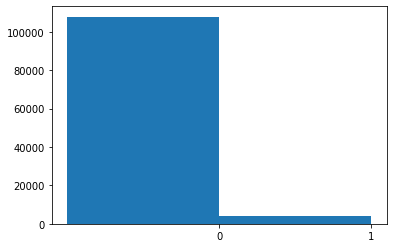

In [5]:
print('Class distribution: ', Counter(y_train.ravel()))
counter_histogram(Counter(y_train.ravel()))

In [6]:
from sklearn.utils import resample
def create_datasets(X_train, y_train, ratio=100):
    datasets = []
    majority = (X_train[y_train == 0], y_train[y_train == 0])
    minority = (X_train[y_train == 1], y_train[y_train == 1])
    if minority[0].shape[0] * ratio > majority[0].shape[0]:
        return [(X_train, y_train)]
    for i in range(majority[0].shape[0] // (minority[0].shape[0] * ratio)):
        x_train, y_train = resample(*majority,
                                    replace=False, n_samples=(minority[0].shape[0] * ratio))
        x_train = np.concatenate([x_train, minority[0]], axis=0)
        y_train = np.concatenate([y_train, minority[1]], axis=0)
        datasets.append((x_train, y_train))
    return datasets

datasets = create_datasets(X_train, y_train)
for i, dataset in enumerate(datasets):
    print('Class distribution of dataset {}: '.format(i), Counter(dataset[1].ravel()))

Class distribution of dataset 0:  Counter({0: 107787, 1: 4213})


## Learning Pipeline

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (StratifiedKFold,
    cross_val_score, )
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

for i, dataset in enumerate(datasets):
    print("Model {} cross-validation.".format(i))
    x_train_match = dataset[0]
    y_train_match = dataset[1]
    pipeline = make_pipeline(
        HistGradientBoostingClassifier(
                    learning_rate=0.21,
                    max_iter=200,
                    max_leaf_nodes=100,
                    min_samples_leaf=100)
    )
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    scores = cross_val_score(pipeline, x_train_match, y_train_match,
                            cv=cv,
                            scoring='f1',
                            n_jobs=-1,
                            verbose=True)
    print("Cross-validation score is {score:.3f},"
          " standard deviation is {err:.3f}"
      .format(score = scores.mean(), err = scores.std()))

Model 0 cross-validation.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-validation score is 0.887, standard deviation is 0.013


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


## Fit on Data and Make Predictions

In [17]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype=int)
        for i, clf in enumerate(self.estimators):
            Y[:, i] = clf.predict(X)
        # apply voting 
        y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y[i] = np.argmax(np.bincount(Y[i,:]))
        return y.astype(np.int)

estimators = []
for i, dataset in enumerate(datasets):
    print("Model {} fitting to data.".format(i))
    x_train_match = dataset[0]
    y_train_match = dataset[1]
    estimators.append(
        HistGradientBoostingClassifier(
                    learning_rate=0.21,
                    max_iter=50,
                    max_leaf_nodes=100,
                    min_samples_leaf=100)
    )
    estimators[i].fit(x_train_match, y_train_match)

ensemble_votes = VotingClassifier(estimators)

Model 0 fitting to data.


In [18]:
preds = ensemble_votes.predict(X_test)
df = pd.DataFrame(preds)
df.to_csv('prediction.csv', index=False, header=False)

Class distribution:  Counter({0: 107787, 1: 4213})
Prediction distribution:  Counter({0: 46306, 1: 1694})


0.9386124228114784

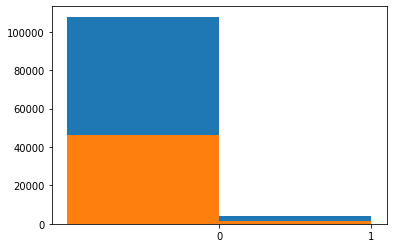

In [19]:
counter_histogram(Counter(y_train.ravel()))
counter_histogram(Counter(preds.ravel()))

print('Class distribution: ', Counter(y_train.ravel()))
print('Prediction distribution: ', Counter(preds.ravel()))
from sklearn.metrics import f1_score
preid = ensemble_votes.predict(X_train)
f1_score(y_train, preid)